# ULS vs TOPAZ

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import netCDF4 as nc4
import pandas as pd
import matplotlib.pyplot as plt
import datetime

from src.utils import modif_plot
from src.utils import save_name
from src.utils import tardisml_utils
from src.utils import cmap_manip
from src.data_preparation import load_data
from src.data_preparation import merge_TOPAZ
from src.data_preparation import colocalise_buoys
from src.modelling import sit_corrected

In [2]:
rootdir = tardisml_utils.get_rootdir()

## Import ULS .netcdf

In [173]:
buoy = 'a'  # a/b/c/d

In [174]:
idir = '/scratch/project_465000269/edelleo1/Leo/SIT_observations/ULS_BGEP/netcdf/'

In [175]:
ifile = f'uls{buoy.upper()}_2003_2018.nc'

In [176]:
nc = nc4.Dataset(f'{idir}{ifile}', mode='r')
sit = xr.open_dataset(xr.backends.NetCDF4DataStore(nc))['sit']
sit_std = xr.open_dataset(xr.backends.NetCDF4DataStore(nc))['sit_std']

In [177]:
lat = xr.open_dataset(xr.backends.NetCDF4DataStore(nc))['lat']
lon = xr.open_dataset(xr.backends.NetCDF4DataStore(nc))['lon']

In [178]:
chrono = pd.DataFrame({'date':pd.to_datetime(sit.time)})

In [179]:
chrono_dt_uls = np.array([dt.date() for dt in chrono.date])

In [180]:
# apply smoother

In [181]:
from src.data_preparation import running_mean as rm

In [182]:
ndays = 7

In [183]:
smooth_data = rm.center_running_mean(sit.to_numpy(), ndays, npd=1)

/users/edelleo1/tardis/tardis-ml/src/data_preparation/running_mean.py:40: RuntimeWarning: Mean of empty slice
  window_average = np.nanmean(arr[i-window_size//2:i+window_size//2])
/users/edelleo1/tardis/tardis-ml/src/data_preparation/running_mean.py:49: RuntimeWarning: Mean of empty slice
  window_average = np.nanmean(arr[-idx:-1])


In [184]:
smooth_std = rm.center_running_mean(sit_std.to_numpy(), ndays, npd=1)

In [185]:
sit_smooth = np.array(smooth_data)

In [186]:
sit_std_smooth = np.array(smooth_std)

In [187]:
# smooth data to xarray

In [188]:
da = xr.DataArray(
    data=sit_smooth,
    dims=["time"],
    coords=dict(
        time=(['time'], sit.time.data)
    ),
    attrs=dict(
        standard_name='sit',
        description="SIT with averaging window over 1 week",
        long_name='mean sea ice thickness',
        unit='m',
        ULS=f'BGEP {buoy.upper()}'
    ),
)


In [189]:
sit_std2 = xr.DataArray(
    data=sit_std_smooth,
    dims=["time"],
    coords=dict(
        time=(['time'], sit_std.time.data)
    ),
    attrs=dict(
        standard_name='sit',
        description="SIT with averaging window over 1 week",
        long_name='std sea ice thickness',
        unit='m',
        ULS=f'BGEP {buoy.upper()}'
    ),
)


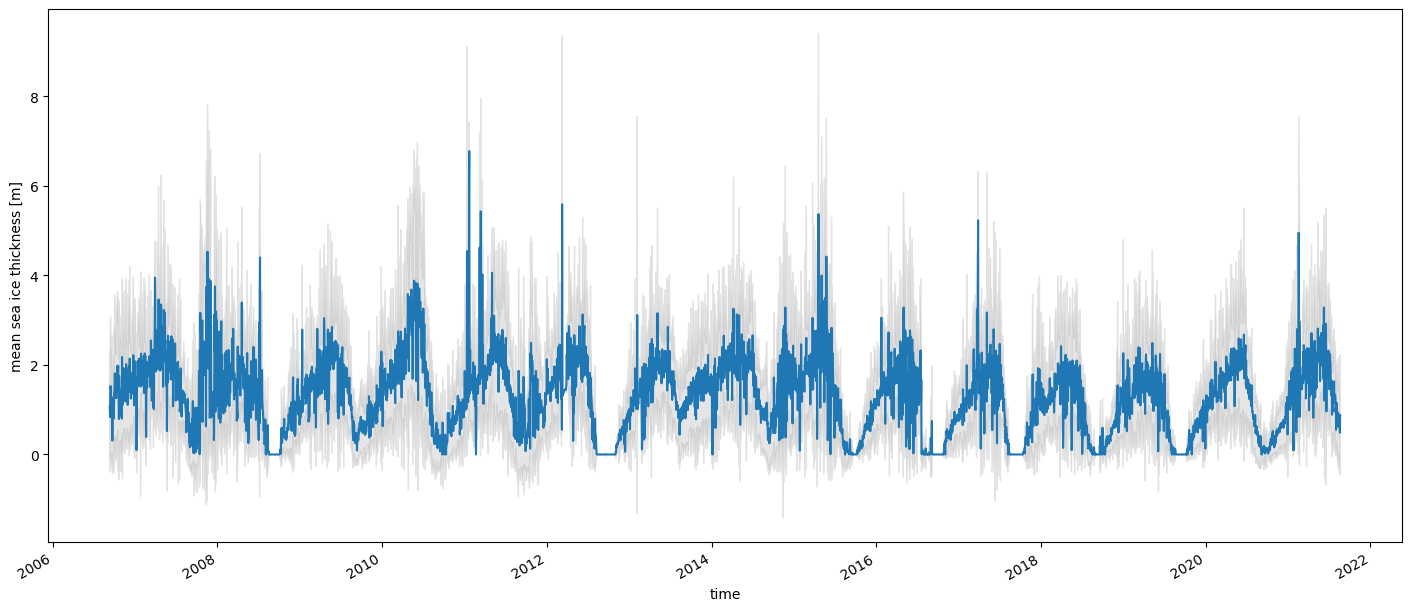

In [145]:
fig, ax = plt.subplots(figsize=(14, 6), constrained_layout=True)

sit.plot()
plt.fill_between(chrono_dt_uls, sit+sit_std, sit-sit_std, color='grey', alpha=0.2)

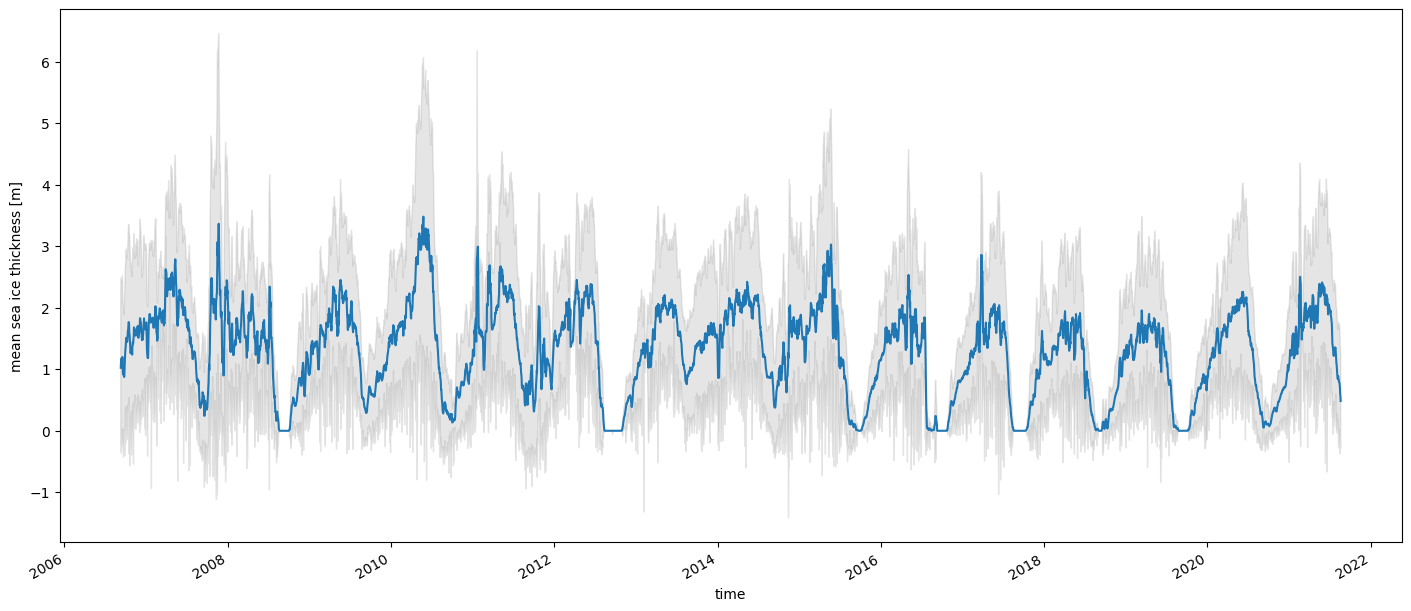

In [146]:
fig, ax = plt.subplots(figsize=(14, 6), constrained_layout=True)

da.plot()
plt.fill_between(chrono_dt_uls, da+sit_std2, sit-sit_std, color='grey', alpha=0.2)

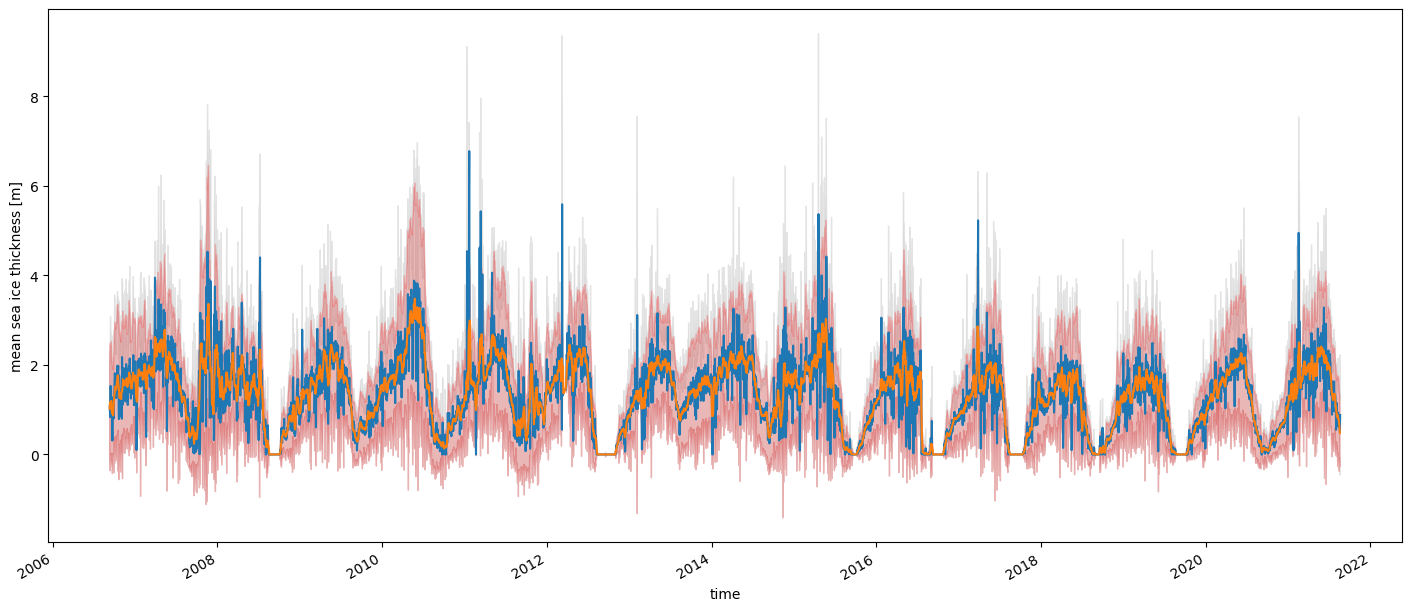

In [147]:
fig, ax = plt.subplots(figsize=(14, 6), constrained_layout=True)

sit.plot()
plt.fill_between(chrono_dt_uls, sit+sit_std, sit-sit_std, color='grey', alpha=0.2)

da.plot()
plt.fill_between(chrono_dt_uls, da+sit_std2, sit-sit_std, color='red', alpha=0.2)

In [190]:
sit = da

sit_std = sit_std2

## Import TOPAZ .netcdf

In [28]:
# sit_ml, chrono_dt_ml, sit_na, sit_bl = merge_TOPAZ.load(return_na=True, return_bl=True)

-------------------

In [29]:
ipath = 'Leo/results/lstm_230919-170402/'
ml_name ='LSTM'



ifile = f'{rootdir}{ipath}'
m2000 = sit_corrected.SITCorrected(ifile, name=ml_name, verbose=0, objective='apply')

In [30]:
#  Reconstruct SIT values 
m2000.reconstruct_sit()
m2000.compute_mean(sic_min=0.15)

In [31]:
m2000??

In [32]:
# sit_ml.mean(dim=('x','y')).plot()
# sit_bl.mean(dim=('x','y')).plot()
# sit_na.mean(dim=('x','y')).plot()

In [33]:
sit_ml = m2000.sit
sit_na = m2000.sit_na
sit_bl = m2000.sit_bl

In [34]:
m2000.sit_m

<xarray.DataArray (time: 4339)>
array([1.55289902, 1.56291996, 1.56526009, ..., 0.98183323, 0.98506828,
       0.99189959])
Coordinates:
  * time     (time) datetime64[ns] 1999-01-01 1999-01-02 ... 2010-11-17

In [35]:
chrono_dt_ml = np.array([dt.date() for dt in m2000.chrono.date])

In [36]:
chrono_dt_ml

array([datetime.date(1999, 1, 1), datetime.date(1999, 1, 2),
       datetime.date(1999, 1, 3), ..., datetime.date(2010, 11, 15),
       datetime.date(2010, 11, 16), datetime.date(2010, 11, 17)],
      dtype=object)

In [37]:
chrono_dt_uls

array([datetime.date(2003, 8, 14), datetime.date(2003, 8, 15),
       datetime.date(2003, 8, 16), ..., datetime.date(2021, 8, 26),
       datetime.date(2021, 8, 27), datetime.date(2021, 8, 28)],
      dtype=object)

-------------------

In [38]:
# Cap negative value at 0 m (while keeping nan)
sit_ml = (sit_ml.where((0<sit_ml), 0)).where(np.isfinite(sit_ml))

## Colocate TOPAZ to ULS (time/space)

In [191]:
sit_ml_loc, lats, lons, valid_ll = colocalise_buoys.get_closest_arr(lat, lon, chrono_dt_uls, sit_ml, chrono_dt_ml)

In [192]:
sit_na_loc, _, _, _ = colocalise_buoys.get_closest_arr(lat, lon, chrono_dt_uls, sit_na, chrono_dt_ml)

In [193]:
sit_bl_loc, _, _, _ = colocalise_buoys.get_closest_arr(lat, lon, chrono_dt_uls, sit_bl, chrono_dt_ml)

## Comparison: Plot - save results

In [194]:
date_first_uls = chrono_dt_uls[0]
date_last_uls = chrono_dt_uls[-1]

In [195]:
date_min = date_first_uls  # datetime.datetime(2011,1,1)
# date_max = date_last_uls  # datetime.datetime(2020,1,1)
date_max = datetime.datetime(2010,12,31)

In [196]:
odir = f'{rootdir}Leo/results/ULS_BGEP/'
ofile = f'uls{buoy.upper()}_SIT_TOPAZ_{date_min.year}_{date_max.year}_01.png'

In [197]:
# detect if there is a gap in chrono
increment_days = chrono_dt_uls[1:]-chrono_dt_uls[:-1]  # number of days between 2 dates
mask_gap = np.array([x.days>1 for x in increment_days] + [False])

sit_plt = sit.copy()
sit_na_loc_plt = sit_na_loc.copy()
sit_bl_loc_plt = sit_bl_loc.copy()
sit_ml_loc_plt = sit_ml_loc.copy()

if np.any(mask_gap):
    sit_plt[mask_gap] = np.nan
    sit_na_loc_plt[mask_gap[valid_ll]] = np.nan
    sit_bl_loc_plt[mask_gap[valid_ll]] = np.nan
    sit_ml_loc_plt[mask_gap[valid_ll]] = np.nan
    

Figure saved as : /scratch/project_465000269/edelleo1/Leo/results/ULS_BGEP/ulsA_SIT_TOPAZ_2003_2010_02.png


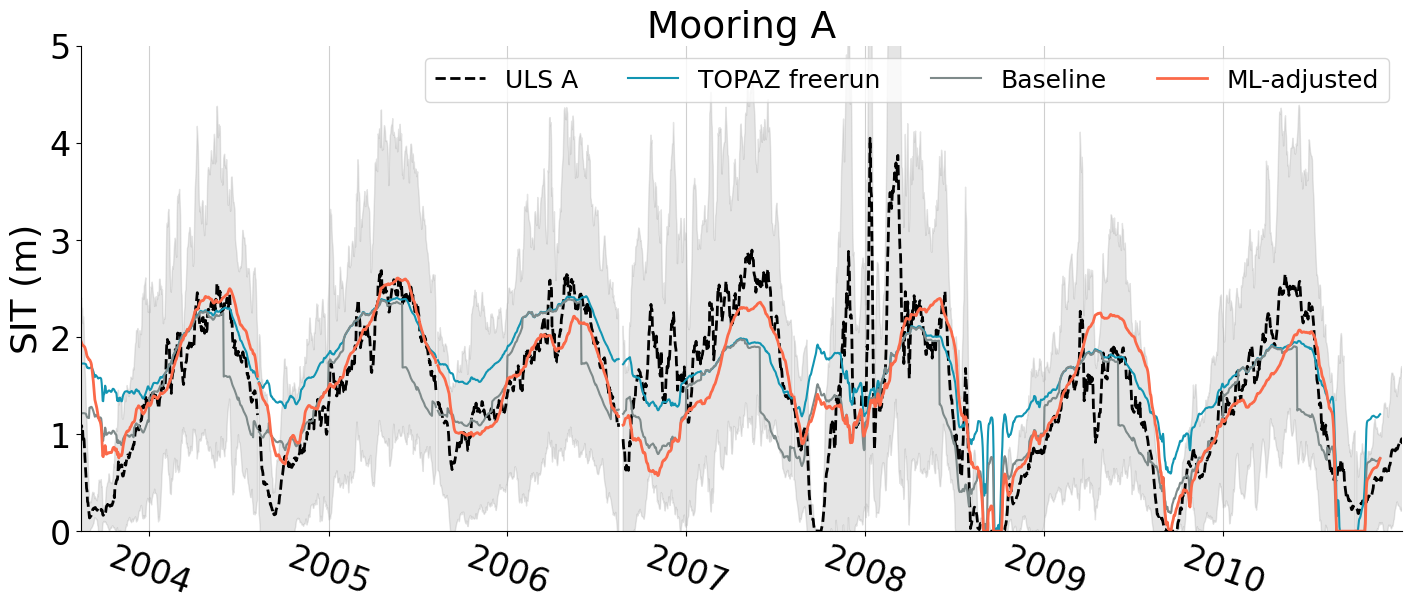

In [198]:
fig, ax = plt.subplots(figsize=(14, 6), constrained_layout=True)

# ULS
# plt.plot(chrono_dt_uls, sit, c='k', ls='none', lw=2, label=f'ULS {buoy.upper()}', marker='+')
plt.plot(chrono_dt_uls, sit_plt, c='k', ls='--', lw=2, label=f'ULS {buoy.upper()}')
plt.fill_between(chrono_dt_uls, sit+sit_std, sit-sit_std, color='grey', alpha=0.2, where=~mask_gap)

# TOPAZ
plt.plot(chrono_dt_uls[valid_ll], sit_na_loc_plt, label='TOPAZ freerun', c='#1295B2')
plt.plot(chrono_dt_uls[valid_ll], sit_bl_loc_plt, label='Baseline', c='#7E8A8A')
plt.plot(chrono_dt_uls[valid_ll], sit_ml_loc_plt, label='ML-adjusted', c='#FB6949', lw=2)

ax.set_ylim([0, 5])
ax.set_xlim([date_min, date_max])


ax.set_ylabel('SIT (m)')
ax.set_title(f'Mooring {buoy.upper()}')
plt.legend(fontsize=18, ncol=4)
ax.spines[['right', 'top']].set_visible(False)
ax.xaxis.grid(alpha=0.6)


modif_plot.resize(fig, s=24, rx=-20)

savefig=True
if savefig:
    ofile = save_name.check(f"{odir}", ofile)
    plt.savefig(f"{odir}{ofile}", dpi=124, facecolor='white')
    print(f'Figure saved as : {odir}{ofile}')


## Plot yearly SIT

plot each month/daily, to observe the seasonal cycle  
one curve per year

In [47]:
# sity = sit.resample(time='1Y')

In [48]:
sity = sit.groupby('time.year')

In [49]:
years = sity.groups.keys()
list_colors = cmap_manip.extract_Ncolors(len(years), cmap='magma')

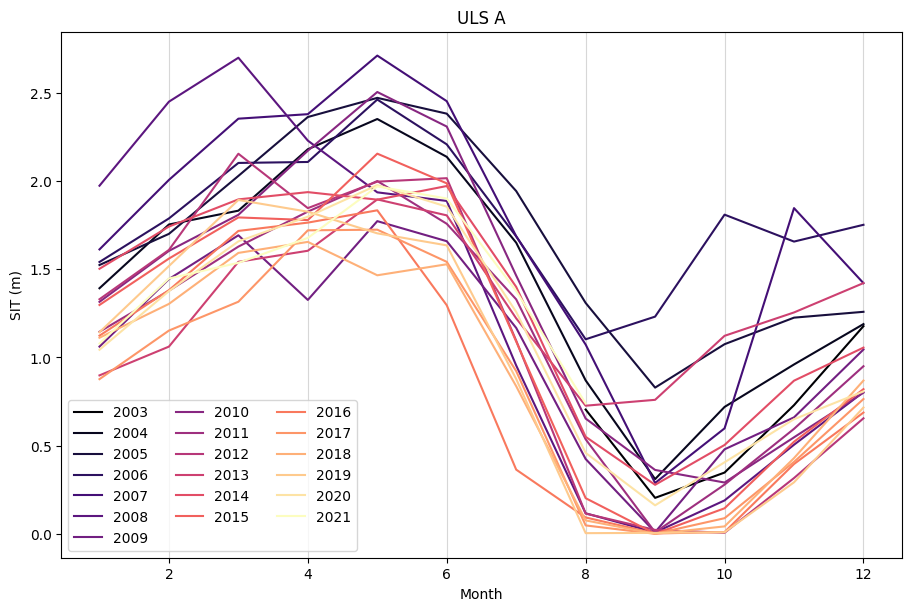

In [50]:
fig, ax = plt.subplots(figsize=(9, 6), constrained_layout=True)

for yr, cl in zip(years, list_colors):
    sit.isel(time=slice(sity.groups[yr][0], sity.groups[yr][-1])).groupby('time.month').mean().plot(label=yr, c=cl)
    
plt.grid(axis='x', alpha=0.5)
plt.legend(loc='lower left', ncols=3)
plt.title(f'ULS {buoy.upper()}')

ax.set_xlabel('Month')
ax.set_ylabel('SIT (m)');

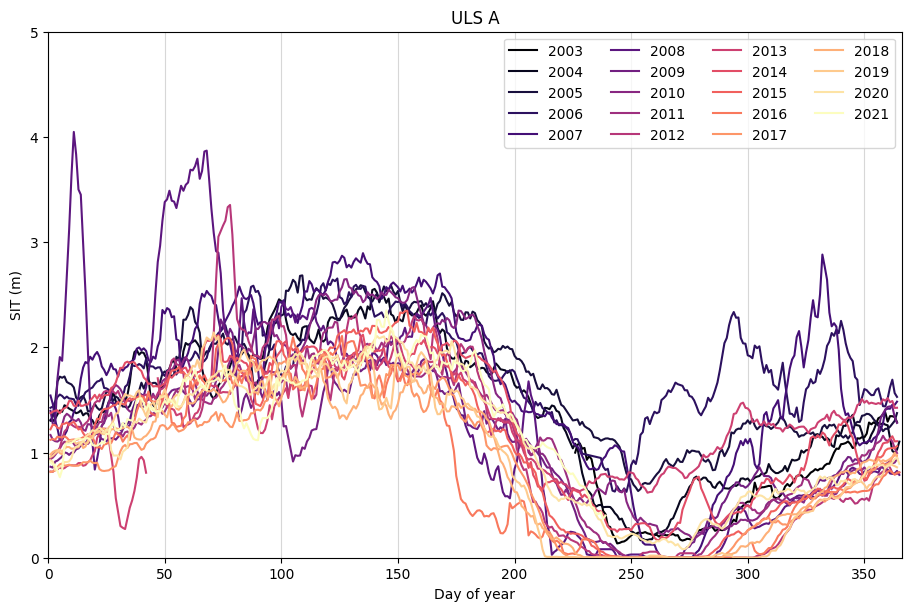

In [51]:
fig, ax = plt.subplots(figsize=(9, 6), constrained_layout=True)

for yr, cl in zip(years, list_colors):
    ydays = [chrono_dt_uls[idx].timetuple().tm_yday for idx in range(sity.groups[yr][0], sity.groups[yr][-1])]
    plt.plot(ydays, sit.isel(time=slice(sity.groups[yr][0], sity.groups[yr][-1])), label=yr, c=cl)
    
    
plt.grid(axis='x', alpha=0.5)
plt.legend(loc='upper right', ncols=4)
plt.title(f'ULS {buoy.upper()}')

ax.set_xlabel('Day of year')
ax.set_ylabel('SIT (m)')

ax.set_ylim([0, 5])
ax.set_xlim([0, 366]);

In [52]:
sit_ml_locDA = xr.DataArray(sit_ml_loc, 
                coords={'time': sit.time[valid_ll]},
                dims=["time"])

In [53]:
sity_ml = sit_ml_locDA.groupby('time.year')

In [54]:
years = sity_ml.groups.keys()
list_colors = cmap_manip.extract_Ncolors(len(years), cmap='magma')

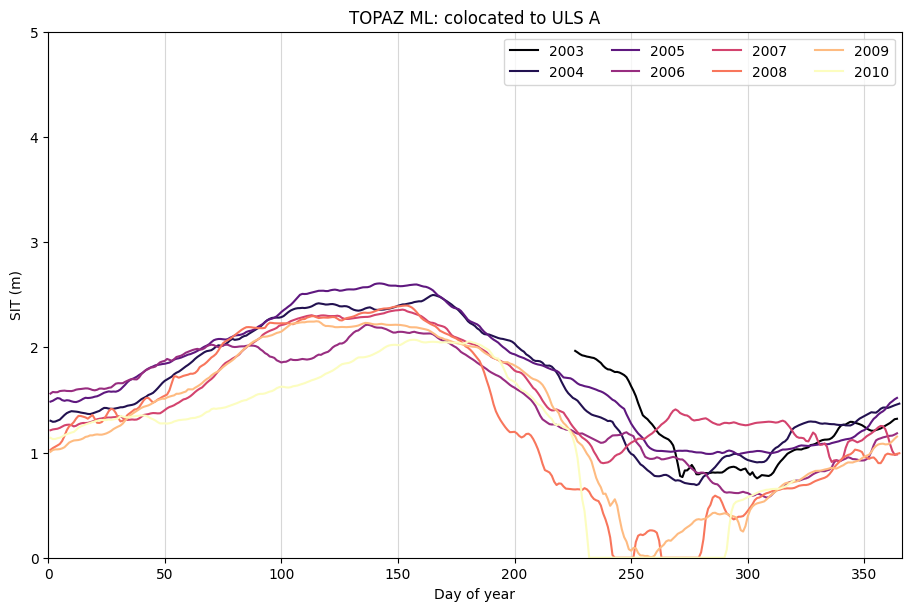

In [55]:
fig, ax = plt.subplots(figsize=(9, 6), constrained_layout=True)

for yr, cl in zip(years, list_colors):
        
    ydays = [chrono_dt_uls[idx].timetuple().tm_yday for idx in range(sity_ml.groups[yr][0], sity_ml.groups[yr][-1])]
    plt.plot(ydays, sit_ml_locDA.isel(time=slice(sity_ml.groups[yr][0], sity_ml.groups[yr][-1])), label=yr, c=cl)
    
    
plt.grid(axis='x', alpha=0.5)
plt.legend(loc='upper right', ncols=4)
plt.title(f'TOPAZ ML: colocated to ULS {buoy.upper()}')

ax.set_xlabel('Day of year')
ax.set_ylabel('SIT (m)')

ax.set_ylim([0, 5])
ax.set_xlim([0, 366]);

# Scatter plot

In [152]:
sit_ml_locDA = xr.DataArray(sit_ml_loc, 
                coords={'time': sit.time[valid_ll]},
                dims=["time"])

In [153]:
sit_bl_locDA = xr.DataArray(sit_bl_loc, 
                coords={'time': sit.time[valid_ll]},
                dims=["time"])

In [154]:
sity_ml = sit_ml_locDA.groupby('time.year')

In [155]:
years = sity_ml.groups.keys()
list_colors = cmap_manip.extract_Ncolors(len(years), cmap='magma')

In [156]:
first_year = list(years)[0]

In [157]:
last_year = list(years)[-2]

In [158]:
# compute mean correlation and bias 

In [161]:
corrm = xr.corr(sit.isel(time=slice(sity_ml.groups[first_year][0], sity_ml.groups[last_year][-1])),
       sit_ml_locDA.isel(time=slice(sity_ml.groups[first_year][0], sity_ml.groups[last_year][-1])))

biasm = (sit.isel(time=slice(sity_ml.groups[first_year][0], sity_ml.groups[last_year][-1])) - sit_ml_locDA.isel(time=slice(sity_ml.groups[first_year][0], sity_ml.groups[last_year][-1]))).mean()

In [162]:
from sklearn.metrics import r2_score

In [164]:
r2m = r2_score(sit.isel(time=slice(sity_ml.groups[first_year][0], sity_ml.groups[last_year][-1])).dropna(dim='time'),
               sit_ml_locDA.isel(time=slice(sity_ml.groups[first_year][0], sity_ml.groups[last_year][-1])).dropna(dim='time'))

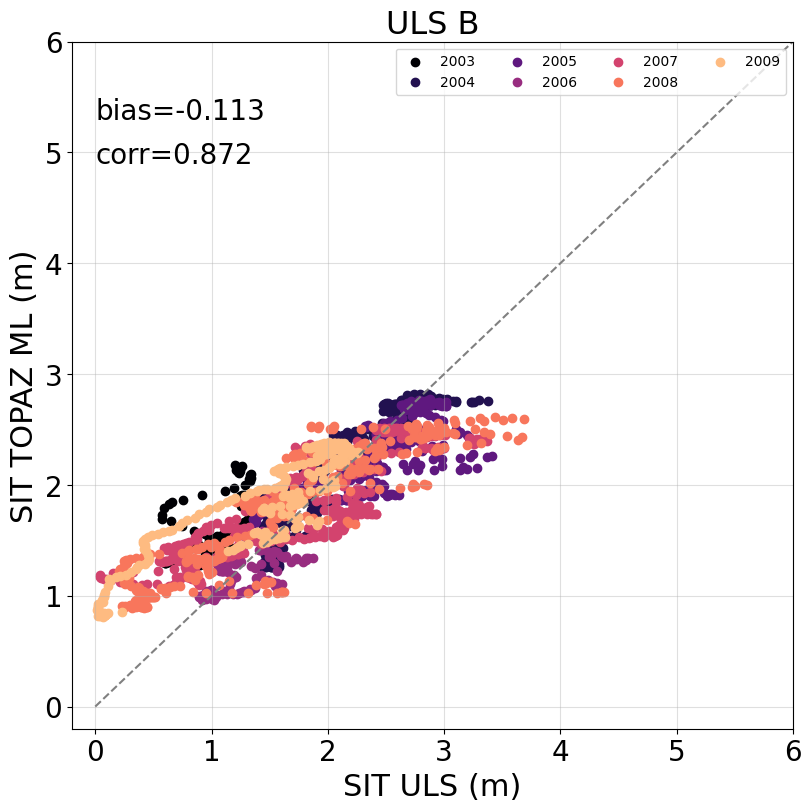

In [166]:
fig, ax = plt.subplots(figsize=(8, 8), constrained_layout=True)

# remove 2019 because not the same number of days
for yr, cl in zip(list(years)[:-1], list_colors):
    ydays = [chrono_dt_uls[idx].timetuple().tm_yday for idx in range(sity_ml.groups[yr][0], sity_ml.groups[yr][-1])]
    plt.scatter(sit.isel(time=slice(sity_ml.groups[yr][0], sity_ml.groups[yr][-1])), 
                sit_ml_locDA.isel(time=slice(sity_ml.groups[yr][0], sity_ml.groups[yr][-1])), label=yr, color=cl)
     

smin = 0
smax = 6
plt.plot([smin, smax], [smin, smax], ls='--', c='grey')

plt.grid(alpha=0.4, zorder=-10)
plt.legend(loc='upper right', ncols=4)
plt.title(f'ULS {buoy.upper()}')

ax.set_xlabel('SIT ULS (m)')
ax.set_ylabel('SIT TOPAZ ML (m)');

ax.set_ylim([smin-0.2, smax])
ax.set_xlim([smin-0.2, smax]);

# ax.annotate('r²=',(0, smax-0.3))
ax.annotate(f'bias={biasm.data:.03f}',(0, smax-0.7))
ax.annotate(f'corr={corrm.data:.03f}',(0, smax-1.1))



modif_plot.resize(fig, s=20)

## Compute errors 

In [68]:
# for table:
# print RMSE, BIAS of ML and baseline
# on average over all years and seasonally

In [167]:
sits_ml = sit_ml_locDA.groupby('time.season')

In [168]:
sits_bl = sit_bl_locDA.groupby('time.season')

In [169]:
sits_uls = sit.groupby('time.season')
# DataArrayGroupBy, grouped over 'season'
# 4 groups with labels 'DJF', 'JJA', 'MAM', 'SON'.

In [170]:
seasons = ['DJF', 'MAM', 'JJA', 'SON']

In [171]:
bias_season = np.array([(sits_ml[saison] - sits_uls[saison]).mean() for saison in seasons])

In [172]:
rmse_season = np.array([np.sqrt((np.square(sits_ml[saison]-sits_uls[saison])).mean()) for saison in seasons])

In [173]:
rmsem = rmse_season.mean()

In [174]:
corr_season = np.array([xr.corr(sits_ml[saison],sits_uls[saison]) for saison in seasons])

In [175]:
corrm = corr_season.mean()

---------------

### all year

In [47]:
from scipy import stats

# corr between sit[valid_ll] and sit_ml_loc
x = sit[valid_ll]
y = sit_ml_loc

# x = sit[valid_ll]
# y = sit_bl_loc

# remove nan
tp = y[~np.isnan(x)]  # topaz
ref = x[~np.isnan(x)]  # reference = obs

c_val, p_val = stats.pearsonr(tp, ref)  # returns correlation value, p value

rmse = np.sqrt((np.square(tp-ref)).mean())

bias = (tp - ref).mean()

print(f'mean corr:   {c_val:.03f}     p value:    {p_val:.06f}')
print(f'rmse  :      {rmse.data:.03f}')
print(f'bias  :      {bias.data:.03f}')

In [ ]:
# differents ways of computing correlation and p-test

# stats.linregress(x[~np.isnan(x)],y[~np.isnan(x)])
# np.corrcoef(x[~np.isnan(x)],y[~np.isnan(x)])

In [223]:
cc = xr.corr(sits_uls['DJF'], sits_ml['DJF'])

In [224]:
cc

<xarray.DataArray ()>
array(0.6123513)

---------------

In [176]:
bias_bl_season = np.array([(sits_bl[saison] - sits_uls[saison]).mean() for saison in ['DJF', 'MAM', 'JJA', 'SON']])

In [177]:
biasm_bl = bias_bl_season.mean()

In [178]:
rmse_bl_season = np.array([np.sqrt((np.square(sits_bl[saison]-sits_uls[saison])).mean()) for saison in ['DJF', 'MAM', 'JJA', 'SON']])

In [179]:
rmsem_bl = rmse_bl_season.mean()

In [180]:
corr_bl_season = np.array([xr.corr(sits_bl[saison],sits_uls[saison]) for saison in seasons])

In [181]:
corrm_bl= corr_bl_season.mean()

---------------

In [182]:
print(f'ULS {buoy.upper()}:    [ML-adjusted - ULS] \n')
print('mean Bias    |      mean  RMSE   |   mean corr')
print(f'{biasm.data:.03f}                {rmsem:.03f}            {corrm:.03f}')

# print('Bias')
print('\n\tDJF     |   MAM     |    JJA      |    SON   ')
print(f'Bias\t{bias_season[0]:.03f}      {bias_season[1]:.03f} \
      {bias_season[2]:.03f}        {bias_season[3]:.03f}')

print(f'RMSE\t{rmse_season[0]:.03f}      {rmse_season[1]:.03f} \
      {rmse_season[2]:.03f}        {rmse_season[3]:.03f}')

print(f'Corr\t{corr_season[0]:.03f}      {corr_season[1]:.03f} \
      {corr_season[2]:.03f}        {corr_season[3]:.03f}')

ULS B:    [ML-adjusted - ULS] 

mean Bias    |      mean  RMSE   |   mean corr
-0.113                0.405            0.684

	DJF     |   MAM     |    JJA      |    SON   
Bias	-0.018      -0.050       0.208        0.282
RMSE	0.355      0.307       0.502        0.457
Corr	0.612      0.628       0.903        0.592


In [183]:
print(f'ULS {buoy.upper()}:    [Baseline - ULS] \n')
print('mean Bias    |      mean  RMSE    |    corr')
print(f'{biasm_bl:.03f}                {rmsem_bl:.03f}            {corrm_bl:.03f}')


print('\n\tDJF     |   MAM     |    JJA      |    SON   ')
print(f'Bias\t{bias_bl_season[0]:.03f}      {bias_bl_season[1]:.03f} \
      {bias_bl_season[2]:.03f}        {bias_bl_season[3]:.03f}')


print(f'RMSE\t{rmse_bl_season[0]:.03f}      {rmse_bl_season[1]:.03f} \
      {rmse_bl_season[2]:.03f}        {rmse_bl_season[3]:.03f}')

print(f'Corr\t{corr_bl_season[0]:.03f}      {corr_bl_season[1]:.03f} \
      {corr_bl_season[2]:.03f}        {corr_bl_season[3]:.03f}')

ULS B:    [Baseline - ULS] 

mean Bias    |      mean  RMSE    |    corr
-0.034                0.440            0.703

	DJF     |   MAM     |    JJA      |    SON   
Bias	0.015      -0.183       -0.282        0.314
RMSE	0.302      0.350       0.621        0.487
Corr	0.749      0.649       0.837        0.576
